In [28]:
import os
import numpy as np

from itertools import product
from collections import defaultdict

import itertools 

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
# %matplotlib widget
%matplotlib inline


import mpl_toolkits.axisartist as axisartist
# import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
import matplotlib

from matplotlib import cm
from matplotlib.colors import ListedColormap#,LinearSegmentedColormap

matplotlib.rcParams['font.family'] = 'monospace'

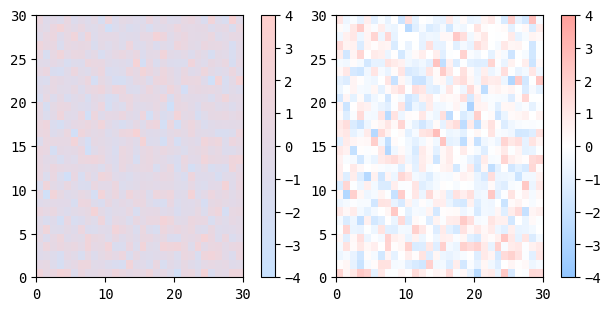

In [29]:
colors = list()
# with plt.style.context("default"):
with plt.style.context("seaborn-v0_8-pastel"):
    for i, color in enumerate(plt.rcParams['axes.prop_cycle']):
        colors.append(color['color'])
i, j = 1, 0
i, j = 2, 0
d=256

vals = np.ones((d, 4))
for ch in range(3):
    vals[:, ch] = 0.5*np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d) \
    + 0.5*np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)
seq_cmap = ListedColormap(vals)

d=128
vals_up = np.ones((d, 4))
vals_bot = np.ones((d, 4))
for ch in range(3):
    vals_up[:, ch] = np.linspace(matplotlib.colors.to_rgb(colors[j])[ch], 1, d)
    vals_bot[:, ch] = np.linspace(1, matplotlib.colors.to_rgb(colors[i])[ch], d)
div_cmap = ListedColormap(np.vstack((vals_up, vals_bot)))

def plot_examples(colormaps):
    np.random.seed(0)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()
plot_examples([seq_cmap, div_cmap])

In [30]:
class FirstElementHashable(tuple):
    def __eq__(self,comp):
        return self[0] == comp[0]
    def __ne__(self,comp):
        return self[0] != comp[0]
    def __hash__(self):
        return hash((self[0],))

In [31]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd())

In [32]:
markers = ['^', '<', '>', 'v', 'o', 's', 'D', '*']

In [33]:
label_keys = ['optimizer', 'md_full_', 'true_weights']
# ya_keys = ['md_n_iters_', 'md_lr_']
metric_key = 'loss'

In [85]:
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)
run_configs = list()
label_keys_dict = dict()
ya_keys_dict = dict()
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')
    run_configs.append(config)
    
    for k in config:
        if k in label_keys or k == 'seed':
            if not isinstance(config[k], dict):
                if k not in label_keys_dict:
                    label_keys_dict.update({k: {config[k]}})
                else:
                    label_keys_dict[k].add(config[k])

        if k[-1] == '_' and k not in label_keys:
            if k not in ya_keys_dict:
                ya_keys_dict.update({k: {config[k]}})
            else:
                ya_keys_dict[k].add(config[k])
ya_keys_dict
# label_keys_dict
ya_keys = ya_keys_dict.keys()

In [86]:
ya_dict = dict()
for k, v in ya_keys_dict.items():
    l = list()
    for i in v:
        if i is not None:
            l.append({None, i})
    ya_dict.update({k: l})
ya_dict

keys, values = zip(*ya_dict.items())
ya_list = [dict(zip(keys, v)) for v in itertools.product(*values)]
ya_list

[{'md_n_iters_': {50, None}, 'md_lr_': {0.02, None}},
 {'md_n_iters_': {50, None}, 'md_lr_': {0.01, None}},
 {'md_n_iters_': {50, None}, 'md_lr_': {0.05, None}},
 {'md_n_iters_': {100, None}, 'md_lr_': {0.02, None}},
 {'md_n_iters_': {100, None}, 'md_lr_': {0.01, None}},
 {'md_n_iters_': {100, None}, 'md_lr_': {0.05, None}},
 {'md_n_iters_': {200, None}, 'md_lr_': {0.02, None}},
 {'md_n_iters_': {200, None}, 'md_lr_': {0.01, None}},
 {'md_n_iters_': {200, None}, 'md_lr_': {0.05, None}}]

In [87]:
label_keys_dict
# rename id lookup
label_keys_id = {k: {i:val for val, i in enumerate(label_keys_dict[k])} for k in label_keys_dict if k != 'seed'}

In [88]:
label_keys_id # rename id lookup

{'true_weights': {None: 0, True: 1, False: 2},
 'md_full_': {False: 0, True: 1, None: 2}}

In [89]:
label_keys_id = {'true_weights': {False: 1, True: 2, None: 0},
 'md_full_': {None: 1, True: 2, False: 0}}

In [90]:
sparse_run_configs = []
params_set = set()
for i, r in enumerate(runs):
    config = run_configs[i]
    
    sparse_run_configs.append(dict())

    for k, v in config.items():
        if k in label_keys or k in ya_keys:
            continue

        if v is not None:
            sparse_run_configs[-1].update({k: v})
    
    params_set.add(str(sparse_run_configs[-1]))
print(params_set)

params_list =list()
for p in params_set:
    d = eval(p)
    for k in d.keys():
        if isinstance(v, str):
            d[k] = eval(d[k])
        else:
            d[k] = d[k]
    
    for ya_d in ya_list:
        for k, v in ya_d.items():
            d.update({k: v})
    
        params_list.append(d.copy())

len(params_list)  
# params_list


{"{'n_iters': 3000, 'n_peers': 6, 'seed': 0, 'problem': {'name': 'Quadratic', 'id': 0}, 'n_samples': 1000, 'batch_size': 100, 'lr': 0.01}", "{'n_iters': 3000, 'n_peers': 6, 'seed': 0, 'problem': {'name': 'Quadratic', 'id': 0}, 'n_samples': 1000, 'batch_size': 10, 'lr': 0.01}", "{'n_iters': 3000, 'n_peers': 6, 'seed': 0, 'problem': {'name': 'Quadratic', 'id': 0}, 'n_samples': 3000, 'batch_size': 100, 'lr': 0.01}", "{'n_iters': 50, 'n_peers': 11, 'seed': 0, 'problem': {'name': 'Logistic', 'id': 1}, 'n_samples': 3500, 'h_ratio': 0.2, 'batch_size': 5, 'lr': 0.01}", "{'n_iters': 3000, 'n_peers': 4, 'seed': 0, 'problem': {'name': 'Quadratic', 'id': 0}, 'n_samples': 1000, 'batch_size': 10, 'lr': 0.01}"}


45

In [91]:
def params_in_config(params, config):
    # for k in ya_keys:
    #     if config[k] == None:
    #         return True
            
    for k in params:
        if k in ya_keys:
            if config[k] not in params[k]:
                return False
        else:
            if config[k] != params[k]:
                return False
    
    return True

In [92]:
runs_sets = [set() for _ in params_list]
for i, r in enumerate(runs):
    config = run_configs[i]
    for j, params in enumerate(params_list):
        if params_in_config(params, config):
            runs_sets[j].add(FirstElementHashable((r, config)))
    
for i, run_set in enumerate(runs_sets):
    flag = False
    for _, config in run_set:
        for k in ya_keys:
            if config[k] is not None:
                flag = True
    if not flag:
        runs_sets[i] = None
        params_list[i] = None
        
print(len(runs_sets))
params_list 
runs_sets_list = [s for s in runs_sets if s is not None]
params_list = [i for i in params_list if i is not None]
print(len(runs_sets_list))
# print(runs_sets_list)

45
6


In [93]:
for i, j in enumerate(runs_sets_list):
    print(len(j))

4
4
4
4
4
4


In [94]:
def params_dict_to_string(d):
    st = list()
    for k, v in d.items():
        if isinstance(v, str):
            v = eval(v)
            st.append('%s=%s' % (k, v['name']))
        elif isinstance(v, dict):
            st.append('%s=%s' % (k, v['name']))
        else:
            if k[-1] == '_':
                name = k[:-1]
            else:
                name = k
            st.append('%s=%s' % (name, str(v).replace('{','(').replace('}',')') ))
    st = ', '.join(st)
    return st

In [95]:
def title_from_dict(d):
    st = list()
    for k, v in d.items():
        if k not in ya_keys:
            continue
        
        if k[-1] == '_':
            k = k[:-1]
        else:
            k = k
        
        if isinstance(v, str):
            v = eval(v)
            st.append('%s=%s' % (k, v['name']))
        elif isinstance(v, dict):
            st.append('%s=%s' % (k, v['name']))
        elif isinstance(v, set):
            for i in v:
                if i is not None:
                    break
            v = i
            
            st.append('%s=%s' % (k, str(v).replace('{','(').replace('}',')') ))
    st = ', '.join(st)
    return st
    

0
2
1
3
n_iters=50, n_peers=11, problem=Logistic, n_samples=3500, h_ratio=0.2, batch_size=5, lr=0.01, md_n_iters=(None, 50), md_lr=(None, 0.02)
3
0
2
1
n_iters=50, n_peers=11, problem=Logistic, n_samples=3500, h_ratio=0.2, batch_size=5, lr=0.01, md_n_iters=(None, 100), md_lr=(None, 0.02)


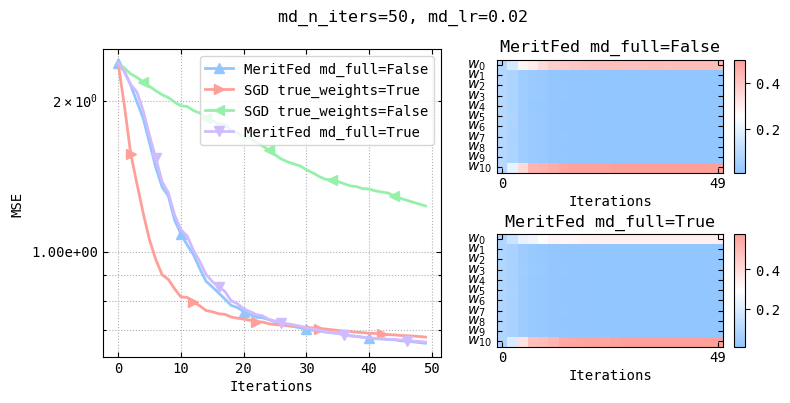

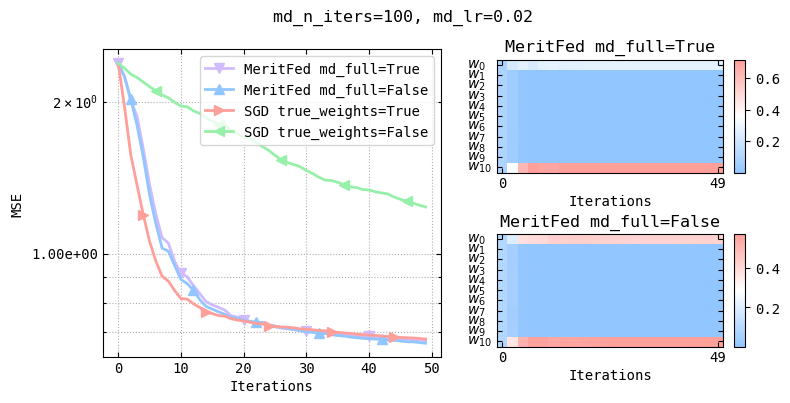

In [96]:
for i, runs in enumerate(runs_sets_list):
    if params_list[i]['problem']['id'] == 0:
        continue
    
    if len(runs) < 1:
        continue
    # title = params_dict_to_string(params_list[i])
    # print(title)
    if 'seed' in params_list[i]:
        params_list[i].pop('seed')
    count = 0
    for j, (r, config) in enumerate(runs):
        if config['md_full_'] is not None:
            count += 1
    count = 2 if count == 0 else count
    fig = plt.figure(figsize=(8, 4))
    gs = GridSpec(nrows=count, ncols=count, width_ratios=[1.5, 1], height_ratios=[1, 1])
    axs = list()
    for j in range(count):
        axs.append(fig.add_subplot(gs[j, 1], axes_class=axisartist.Axes))                  
    ax = fig.add_subplot(gs[:, 0], axes_class=axisartist.Axes)


    count = 0
    for j, (r, config) in enumerate(runs):
        if config['md_n_iters_'] is not None:
            weights = []
            labels = list()
            for rank in range(config['n_peers']):
                k = 'weights_%s' % (str(rank))
                labels.append(r'$w_{%s}$' % (str(rank)))

                history = client.get_metric_history(run_id=r.info.run_id, key=k)
                y = np.array([h.value for h in history])
                x = np.array([h.step for h in history])
                ticks_map = np.linspace(0, len(x)-1, 2*config['n_peers'], endpoint=True).round().astype(int)
                y = [y[j] for j in  ticks_map]
                weights.append(y)
            weights = np.array(weights)#.copy()

            title = list()
            for k in label_keys:
                if isinstance(config[k], dict):
                    name = config[k]['name']
                    if name == 'SGDMD':
                        title.append('MeritFed')
                    else:
                        title.append(name)
                else:
                    if config[k] is not None:
                        if k[-1] == '_':
                            name = k[:-1]
                        else:
                            name = k
                        title.append(name + '=' + str(config[k]))
            title = ' '.join(title)
            axs[count].set_title(title)

            im = axs[count].imshow(weights,  cmap=div_cmap)

            axs[count].set_xlabel('Iterations')
            axs[count].axis["bottom"].label.set_position([10000, 0])

            axs[count].set_xticks([0, len(ticks_map)-1])
            axs[count].set_xticklabels(['0', str(x[-1])])

            axs[count].axis["left"].major_ticklabels.set_ha("left")
            axs[count].set_yticks(np.arange(len(labels)), labels=labels)

            cax = inset_axes(axs[count], width="5%", height="100%", 
                 loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=axs[count].transAxes, borderpad=0)
            cax.yaxis.set_ticks_position("right")
            fig.colorbar(im, cax=cax, format=mtick.FormatStrFormatter('%.1f'))
            count += 1

    # print(title)
    title = title_from_dict(params_list[i])
    # title = ''

    for j, (r, config) in enumerate(runs):
        # if config['true_weights'] == False:
        #     continue
        beg = 0
        end = 5000
        # if config['true_weights'] == False:
        #     continue
        
        
        label = list()
        for k in label_keys:
            if isinstance(config[k], dict):
                name = config[k]['name']
                if name == 'SGDMD':
                    label.append('MeritFed')
                else:
                    label.append(name)
                
            else:
                if config[k] is not None:
                    if k[-1] == '_':
                        name = k[:-1]
                    else:
                        name = k
                    label.append(name + '=' + str(config[k]))
        label = ' '.join(label)
        
        for idx, k in enumerate(label_keys):
            if isinstance(config[k], dict):
                id = config[k]['id']
        
        label_keys_id = {'true_weights': {False: 1, True: 2, None: 0},
 'md_full_': {None: 1, True: 3, False: 0}}
        
        for idx, k in enumerate(label_keys):
            if isinstance(config[k], dict):
                continue
            else:
                # id += 1*(idx-1) + label_keys_id[k][config[k]] - 1
                id += 2*(idx-1) + label_keys_id[k][config[k]] - 1
        id -= 1
        print(id)
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        # y_min = min(y_min, y.min())
        # y = np.log(y-y_min+1e-5)
        ax.plot(x, y,
                 alpha=1, color=colors[id],
                 marker=markers[id], markevery=slice(2*j, len(x), 10), markersize=7,
                 label=label, linewidth=2)

        ax.axis["left"].major_ticklabels.set_ha("left")

    # ax.set_title(title)
    # lim = ax.get_ylim()
    # print(lim)
    # ax.set_ylim((y_min+1e-5, lim[1]))
    ax.set_xlabel('Iterations')
    ax.set_ylabel('MSE')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # ax.set_xscale('log')
    ax.grid(True, which="both", ls='dotted')
    ax.legend()

    # plt.tight_layout()
    name = params_dict_to_string(params_list[i])
    print(name)
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    # plt.savefig(title +'.pdf', bbox_inches='tight')
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    fig.suptitle(title, wrap = True)
    # plt.title(title)
    fig.show()
    # break
